# Regresión Logística vs Árboles de Decisión 

Se van a utilizar ambos modelos para predecir si hay impago o no de ciertos clientes y elegir el mejor modelo

## Lectura de Datos y EDA

In [49]:
# 1. Importar librerías
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from beautifultable import BeautifulTable as BT

from sklearn.model_selection import train_test_split as separar
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Arbol
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE

In [4]:
# 2. Importar datos
df_credit_scoring = pd.read_csv('Credit Scoring.csv', encoding='latin1', delimiter = ';')
df_credit_scoring

,age,job,marital,education,default,Unnamed: 5,Unnamed: 6
0,30,unemployed,married,primary,no,NaN,NaN
1,33,services,married,secondary,no,NaN,NaN
2,35,management,single,tertiary,no,NaN,NaN
3,30,management,married,tertiary,no,NaN,NaN
4,59,blue-collar,married,secondary,no,NaN,NaN
...,...,...,...,...,...,...,...
4427,33,services,married,secondary,no,NaN,NaN
4428,57,self-employed,married,tertiary,yes,NaN,NaN
4429,57,technician,married,secondary,no,NaN,NaN
4430,28,blue-collar,married,secondary,no,NaN,NaN


In [5]:
# Se eliminan las columnas Unnamed: 5 y Unnamed: 6 que se han creado por error:
df_credit_scoring.drop(columns=['Unnamed: 5', 'Unnamed: 6'], inplace=True)

### EDA

In [6]:
df_credit_scoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4432 entries, 0 to 4431
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4432 non-null   int64 
 1   job        4432 non-null   object
 2   marital    4432 non-null   object
 3   education  4432 non-null   object
 4   default    4432 non-null   object
dtypes: int64(1), object(4)
memory usage: 173.2+ KB


In [7]:
# Diferentes valores de cada variable y su cantidad
for column in df_credit_scoring.columns:
    print(df_credit_scoring[column].value_counts())

age
34    231
32    224
31    199
36    188
33    186
35    180
37    161
38    159
30    150
40    142
42    141
41    135
39    130
46    119
43    115
48    114
49    112
45    112
47    108
44    105
28    103
50    101
29     97
53     94
27     94
57     91
51     91
55     90
52     86
58     85
26     77
56     74
54     71
59     71
60     47
25     44
24     24
23     20
61     16
22      9
63      8
64      7
62      7
21      7
19      4
20      3
Name: count, dtype: int64
job
management       965
blue-collar      943
technician       767
admin.           477
services         417
self-employed    183
entrepreneur     168
retired          156
unemployed       128
housemaid        109
student           84
unknown           35
Name: count, dtype: int64
marital
married     2728
single      1193
divorced     511
Name: count, dtype: int64
education
secondary    2277
tertiary     1332
primary       644
unknown       179
Name: count, dtype: int64
default
no     4356
yes      76
Nam

In [8]:
# Se van a analizar los nulos
null_counts = df_credit_scoring.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


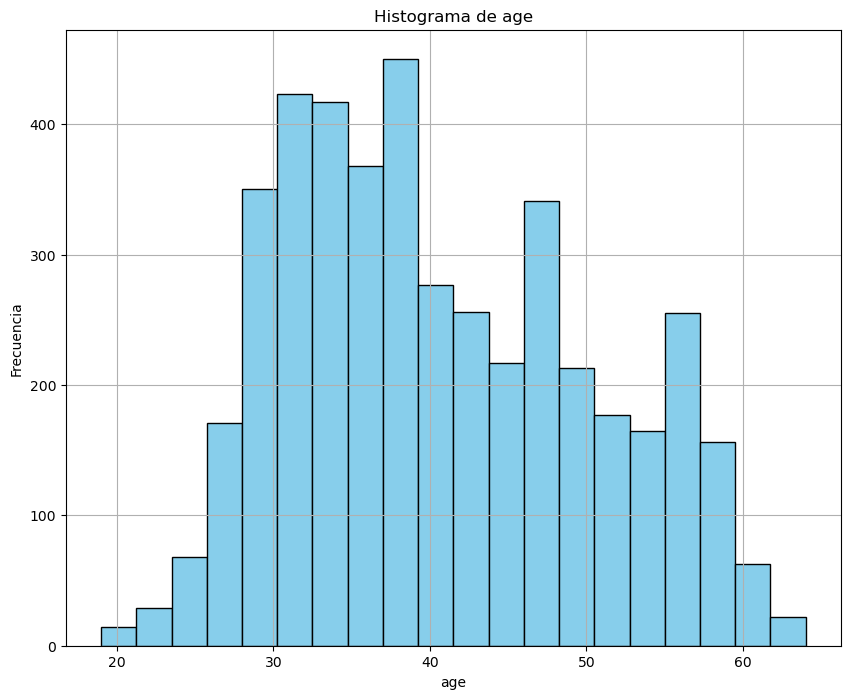

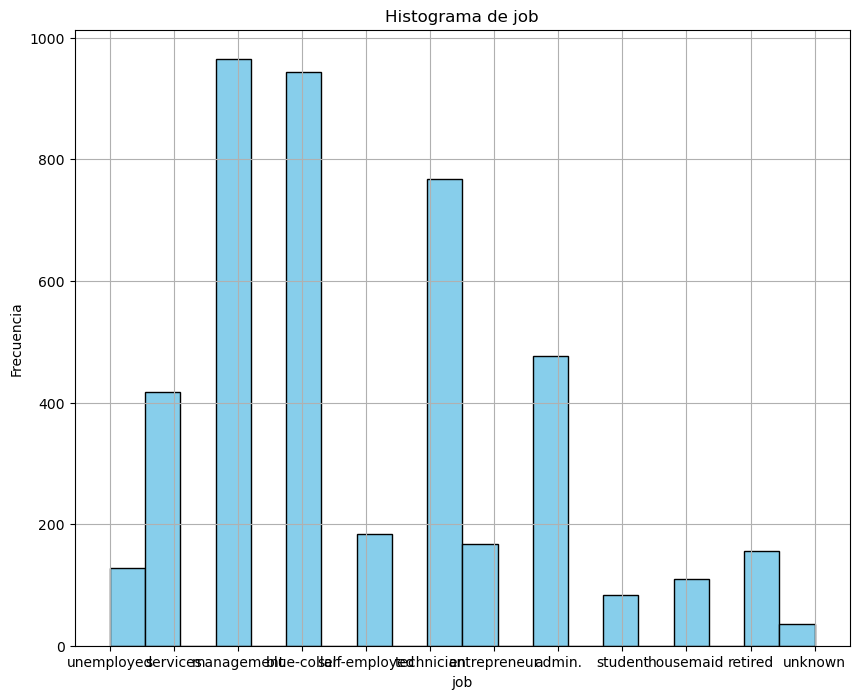

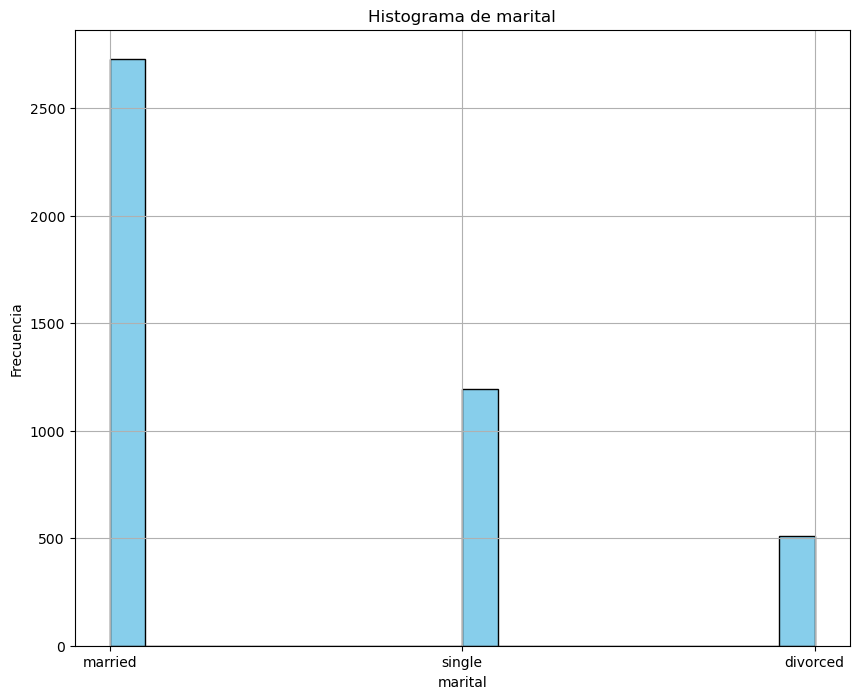

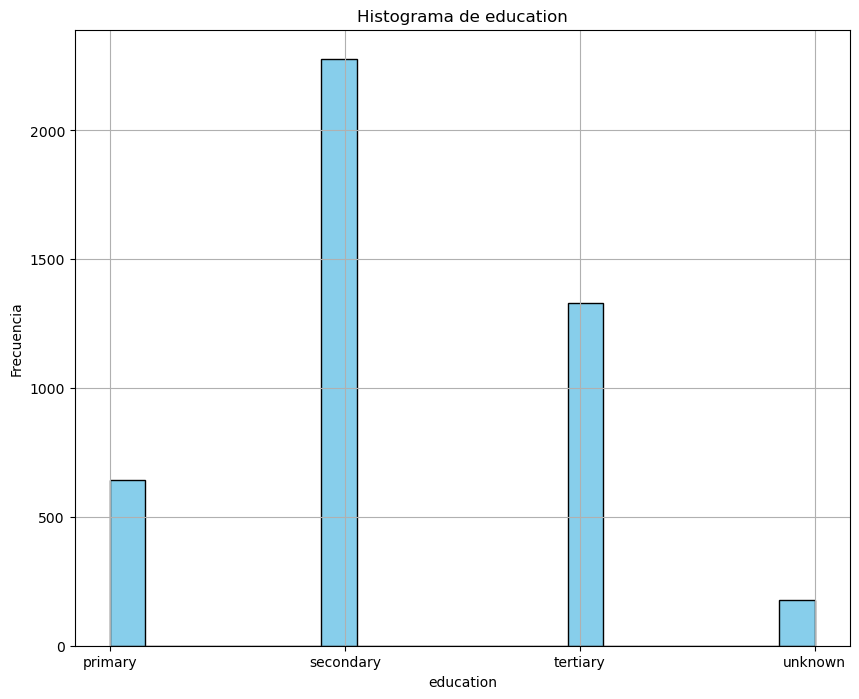

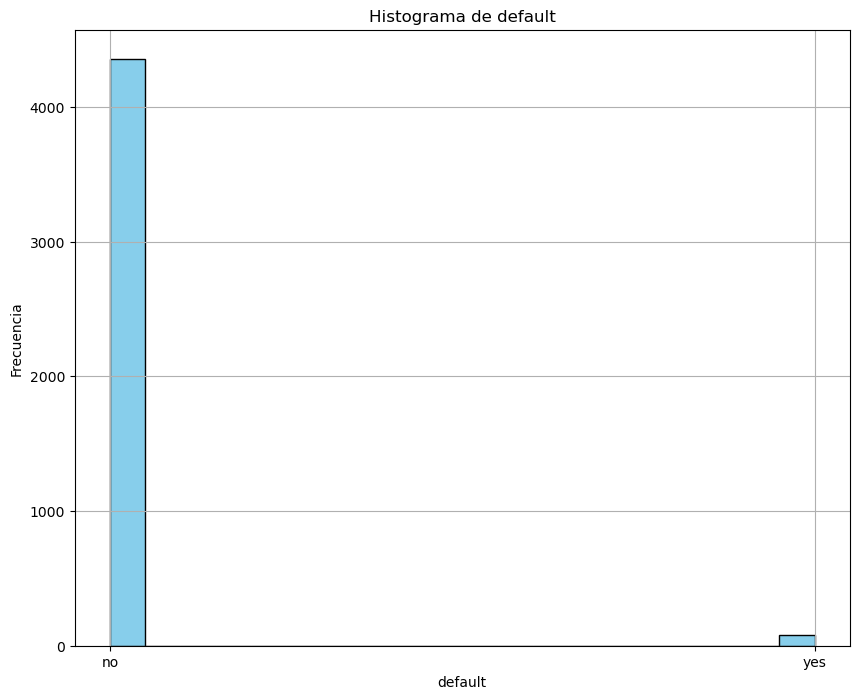

In [9]:
# Visualizar un histograma de cada columna

# Iterar sobre las columnas y crear un histograma para cada una
for column in df_credit_scoring.columns:
    plt.figure(figsize=(10, 8))  # Tamaño de la figura
    plt.hist(df_credit_scoring[column], bins=20, color='skyblue', edgecolor='black')  # Crear el histograma
    plt.title(f'Histograma de {column}')  # Título del histograma
    plt.xlabel(column)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y
    plt.grid(True)  # Activar la cuadrícula
    plt.show()  # Mostrar el histograma

In [46]:
# Cantidad de 'no' y 'yes' de la variable 'default':
df_credit_scoring['default'].value_counts()

default
no     4356
yes      76
Name: count, dtype: int64

Debido al desbalanceo entre 'no' y 'yes', se debe valorar balancearlo:
- Undersampling: Reducir aleatoriamente la cantidad de muestras en la clase mayoritaria para igualar la cantidad de muestras en la clase minoritaria. Esto puede ayudar a evitar el sesgo hacia la clase mayoritaria
- Oversampling: Aumentar aleatoriamente la cantidad de muestras en la clase minoritaria mediante la duplicación de observaciones o la generación de nuevas muestras sintéticas. Esto puede ayudar a mejorar la representación de la clase minoritaria
- Técnicas combinadas: Combinación del undersampling y el oversampling
- SMOTE: Técnica más avanzada que genera muestras sintéticas de la clase minoritaria basadas en vecinos cercanos en el espacio de características

#### Correlaciones

In [10]:
# Variables categóricas -> Encoder ; Variable 'default' -> 0 y 1

encoder = LabelEncoder()
df_credit_scoring_encoder = df_credit_scoring.copy()
categorical_columns = ['job', 'marital', 'education']

for column in categorical_columns:
    df_credit_scoring_encoder[column] = encoder.fit_transform(df_credit_scoring_encoder[column])
    
# Transformación de la variable objetivo default a 0 y 1
df_credit_scoring_encoder['default'] = df_credit_scoring_encoder['default'].map({'no': 0, 'yes': 1})
df_credit_scoring_encoder

,age,job,marital,education,default
0,30,10,1,0,0
1,33,7,1,1,0
2,35,4,2,2,0
3,30,4,1,2,0
4,59,1,1,1,0
...,...,...,...,...,...
4427,33,7,1,1,0
4428,57,6,1,2,1
4429,57,9,1,1,0
4430,28,1,1,1,0


In [13]:
# Mostrar la correlación entre los atributos del conjunto de datos
corr_matrix = df_credit_scoring_encoder.corr()
corr_matrix

,age,job,marital,education,default
age,1.000000,-0.034519,-0.390541,-0.111364,-0.011075
job,-0.034519,1.000000,0.072599,0.170989,0.008777
marital,-0.390541,0.072599,1.000000,0.100660,-0.022265
education,-0.111364,0.170989,0.100660,1.000000,-0.011552
default,-0.011075,0.008777,-0.022265,-0.011552,1.000000


In [14]:
# Se analizan las correlaciones frente a la variable target 'default'
corr_matrix['default'].sort_values(ascending=False)

default      1.000000
job          0.008777
age         -0.011075
education   -0.011552
marital     -0.022265
Name: default, dtype: float64

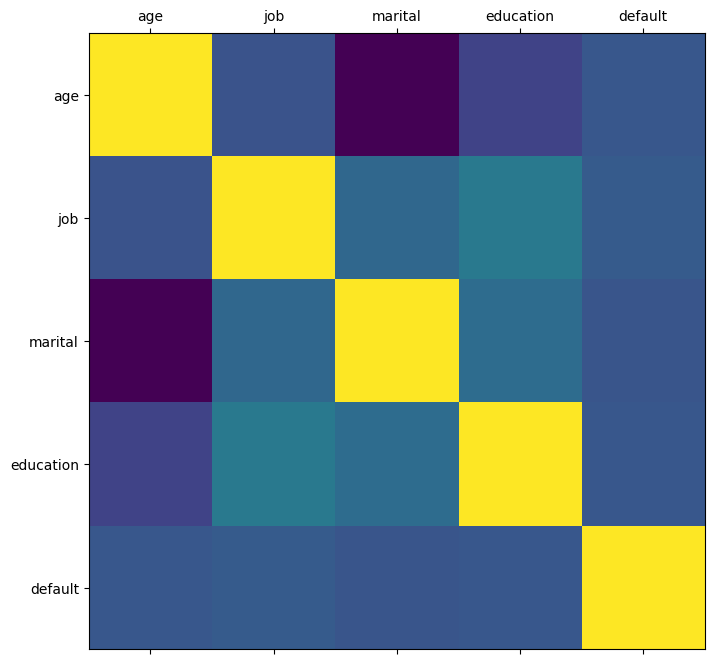

In [15]:
# Representar gráficamente la matriz de correlación
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns);
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns);

### Escalado de datos y Corrección del desbalanceo

In [55]:
# Separación entre variable objetivo y el resto
X = df_credit_scoring_encoder.drop(columns=['default']).values
y = df_credit_scoring_encoder['default'].values

In [56]:
# Escalar los datos
escaladorX = MinMaxScaler()
X_scaled = escaladorX.fit_transform(X.astype('float64'))

In [57]:
# Aplicar SMOTE al conjunto completo de datos. Se va a ampliar la clase minoritaria (1) generando nuevas observaciones basadas en vecinos
smote = SMOTE(sampling_strategy=0.5, random_state=0)  # Por ejemplo, establece la proporción de la clase minoritaria a la mitad de la clase mayoritaria
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Verificar la distribución de las clases después de aplicar SMOTE
print("Distribución de clases después de aplicar SMOTE:")
print(pd.Series(y_resampled).value_counts())

Distribución de clases después de aplicar SMOTE:
0    4356
1    2178
Name: count, dtype: int64


## Regresión Logística

Se van a evaluar dos modelos:
- Sin SMOTE: muestra con las proporciones originales de 0 y 1
- Con SMOTE: muestra con la aplicación de un balanceo de 0 y 1

### División conjunto de datos en Train y Test

In [91]:
# Separar en Entranamiento y Validación SIN SMOTE
X_train, X_test, y_train, y_test = separar(X_scaled, y, test_size=0.25, random_state=0)
print('La forma de X_train es: ', X_train.shape)
print('La forma de y_train es: ', y_train.shape)
print('La forma de X_test es: ', X_test.shape)
print('La forma de y_test es: ', y_test.shape)

La forma de X_train es:  (3324, 4)
La forma de y_train es:  (3324,)
La forma de X_test es:  (1108, 4)
La forma de y_test es:  (1108,)


In [73]:
# Separar en Entranamiento y Validación CON SMOTE
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = separar(X_resampled, y_resampled, test_size=0.25, random_state=0)
print('La forma de X_train es: ', X_train_resampled.shape)
print('La forma de y_train es: ', y_train_resampled.shape)
print('La forma de X_test es: ', X_test_resampled.shape)
print('La forma de y_test es: ', y_test_resampled.shape)

La forma de X_train es:  (4900, 4)
La forma de y_train es:  (4900,)
La forma de X_test es:  (1634, 4)
La forma de y_test es:  (1634,)


### Entrenamiento del modelo

In [69]:
# Ajustar el Modelo SIN SMOTE

LR_model = LR(random_state=0)
LR_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [74]:
# Ajustar el Modelo CON SMOTE

LR_model_resampled = LR(random_state=0)
LR_model_resampled.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=0)

### Predicción

In [75]:
# Hacer las predicciones SIN SMOTE
#y_fit = clasificador.predict(X_train)
y_pred = LR_model.predict(X_test)

In [76]:
# Hacer las predicciones CON SMOTE
#y_fit = clasificador.predict(X_train)
y_pred_resampled = LR_model_resampled.predict(X_test_resampled)

### Evaluación del modelo

In [77]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada SIN SMOTE

cm = CM(y_test, y_pred)
cm

array([[1087,    0],
       [  21,    0]])

El hecho de que la matriz de confusión tenga ceros en la segunda fila indica que no se están prediciendo ninguna instancia de la clase "yes" ó 1 (impago) en el conjunto de pruebas. Esto sugiere que puede haber un desequilibrio en los datos de entrenamiento, lo que está afectando el rendimiento del modelo.

In [78]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada CON SMOTE

cm_resampled = CM(y_test_resampled, y_pred_resampled)
cm_resampled

array([[1095,    0],
       [ 539,    0]])

La matriz de confusión con la aplicación del SMOTE para corregir el desbalanceo nos sigue mostrando que no ha predicho ningún 1 (impago)

In [83]:
# 8.1 Otras métricas para evaluar el modelo SIN SMOTE

# Primero se convierte la matriz de confusión en variables para facilitar su cálculo
tn, fp, fn, tp = cm.ravel()

# Accuracy
accuracy = (tp+tn) / (tp+tn+fp+fn)
print(f"La exactitud/accuracy es de: {accuracy}")

# Precision
precision = tp / (tp+fp)
print(f"La precisión es de: {precision}")

# Recall
recall = tp / (tp+fn)
print(f"La sensibilidad/recall es de: {recall}")

# Specificity
specificity = tn / (tn+fp)
print(f"La especificidad/specificity es de: {specificity}")

# F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"La f1 score es de: {f1}")

La exactitud/accuracy es de: 0.9810469314079422
La precisión es de: nan
La sensibilidad/recall es de: 0.0
La especificidad/specificity es de: 1.0
La f1 score es de: nan


/var/folders/79/rwrch1qx1y7bm5mc3hnnntw00000gn/T/ipykernel_8639/3217267892.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp+fp)


Interpretación:
- El modelo ha interpretado correctamente el 98,10% de las predicciones
- El modelo no ha detectado ningún positivo, por eso la precisión es nula
- De todos los positivos reales que hay, el modelo no ha identificado ninguno, por eso la especificidad es 0
- De todos los negatioa que hay, el modelo ha detectado el 100% de ellos
- El F1 Score no se puede calcular debido a la no clasifiación de positivos

In [84]:
# 8.1 Otras métricas para evaluar el modelo CON SMOTE

# Primero se convierte la matriz de confusión en variables para facilitar su cálculo
tn_resampled, fp_resampled, fn_resampled, tp_resampled = cm_resampled.ravel()

# Accuracy
accuracy_resampled = (tp_resampled+tn_resampled) / (tp_resampled+tn_resampled+fp_resampled+fn_resampled)
print(f"La exactitud/accuracy es de: {accuracy_resampled}")

# Precision
precision_resampled = tp_resampled / (tp_resampled+fp_resampled)
print(f"La precisión es de: {precision_resampled}")

# Recall
recall_resampled = tp_resampled / (tp_resampled+fn_resampled)
print(f"La sensibilidad/recall es de: {recall_resampled}")

# Specificity
specificity_resampled = tn_resampled / (tn_resampled+fp_resampled)
print(f"La especificidad/specificity es de: {specificity_resampled}")

# F1 score
f1_resampled = 2 * (precision_resampled * recall_resampled) / (precision_resampled + recall_resampled)
print(f"La f1 score es de: {f1_resampled}")

La exactitud/accuracy es de: 0.6701346389228886
La precisión es de: nan
La sensibilidad/recall es de: 0.0
La especificidad/specificity es de: 1.0
La f1 score es de: nan


/var/folders/79/rwrch1qx1y7bm5mc3hnnntw00000gn/T/ipykernel_8639/3579690765.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision_resampled = tp_resampled / (tp_resampled+fp_resampled)


Interpretación:
- El modelo ha interpretado correctamente el 67,01% de las predicciones
- El modelo no ha detectado ningún positivo, por eso la precisión es nula
- De todos los positivos reales que hay, el modelo no ha identificado ninguno, por eso la especificidad es 0
- De todos los negatioa que hay, el modelo ha detectado el 100% de ellos
- El F1 Score no se puede calcular debido a la no clasifiación de positivos

In [63]:
'''

# Prueba del modelo

# Se definen los nuevos datos de una muestra

#primero se crea el DataFrame con valores y se aplica el encoder
new_data = [[24, 'management', 'single', 'tertiary']]
df_X_new = pd.DataFrame(new_data, columns = ['age', 'job', 'marital', 'education'])
categorical_columns = ['job', 'marital', 'education']
for column in categorical_columns:
    df_X_new[column] = encoder.transform(df_X_new[column])

#se transforman los datos en un array y se aplica el escalado
X_new = df_X_new.values
# Escalar los datos
X_new_scaled = escaladorX.transform(X_new.astype('float64'))

# Realizar la predicción
prediccion_new = clasificador.predict(X_new_scaled)
print(prediccion_new)

if prediccion_1[0] == 1:
    prediccion_1_str = 'Impaga'
else:
    prediccion_1_str = 'Paga'

print(f"""
La predicción para una persona de {new_data[0]} años, con un trabajo de {new_data[1]}, estado civil de {new_data[2]} 
y una eduación de {new_data[3]} es: {prediccion_1_str}
""")

'''

'\n\n# Prueba del modelo\n\n# Se definen los nuevos datos de una muestra\n\n#primero se crea el DataFrame con valores y se aplica el encoder\nnew_data = [[24, \'management\', \'single\', \'tertiary\']]\ndf_X_new = pd.DataFrame(new_data, columns = [\'age\', \'job\', \'marital\', \'education\'])\ncategorical_columns = [\'job\', \'marital\', \'education\']\nfor column in categorical_columns:\n    df_X_new[column] = encoder.transform(df_X_new[column])\n\n#se transforman los datos en un array y se aplica el escalado\nX_new = df_X_new.values\n# Escalar los datos\nX_new_scaled = escaladorX.transform(X_new.astype(\'float64\'))\n\n# Realizar la predicción\nprediccion_new = clasificador.predict(X_new_scaled)\nprint(prediccion_new)\n\nif prediccion_1[0] == 1:\n    prediccion_1_str = \'Impaga\'\nelse:\n    prediccion_1_str = \'Paga\'\n\nprint(f"""\nLa predicción para una persona de {new_data[0]} años, con un trabajo de {new_data[1]}, estado civil de {new_data[2]} \ny una eduación de {new_data[3]} 

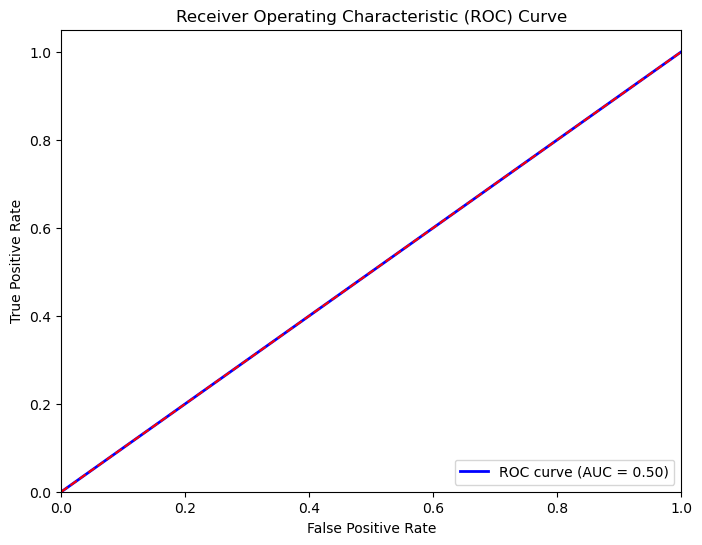

In [85]:
# Curva ROC SIN SMOTE

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Interpretación:**
Es un AUC muy malo, significando que el modelo no es capaz de discriminar entre clases positivas y negativas. Esto se puede deber al desbalanceo entre 0 y 1.

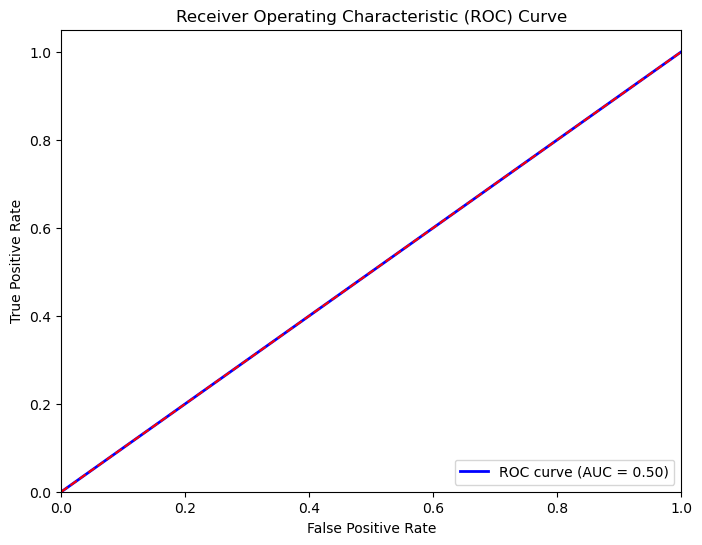

In [86]:
# Curva ROC CON SMOTE

# Calcular la curva ROC
fpr_resampled, tpr_resampled, thresholds_resampled = roc_curve(y_test_resampled, y_pred_resampled)
roc_auc_resampled = auc(fpr_resampled, tpr_resampled)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_resampled, tpr_resampled, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_resampled)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

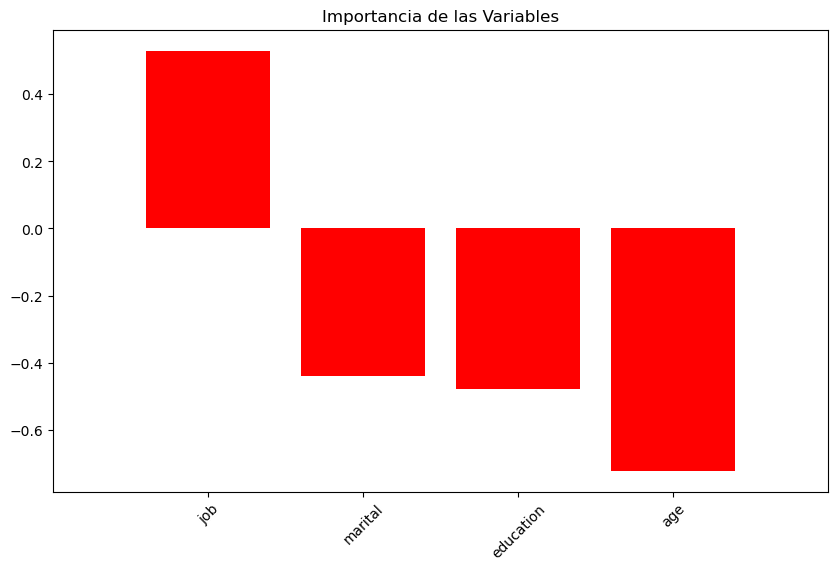

In [65]:
# Obtener la importancia de las variables SIN SMOTE
importance = LR_model.coef_[0]

# Ordenar las variables por importancia
indices = np.argsort(importance)[::-1]

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.title("Importancia de las Variables")
plt.bar(range(X_train.shape[1]), importance[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), df_credit_scoring_encoder.drop(columns=['default']).columns[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.show()

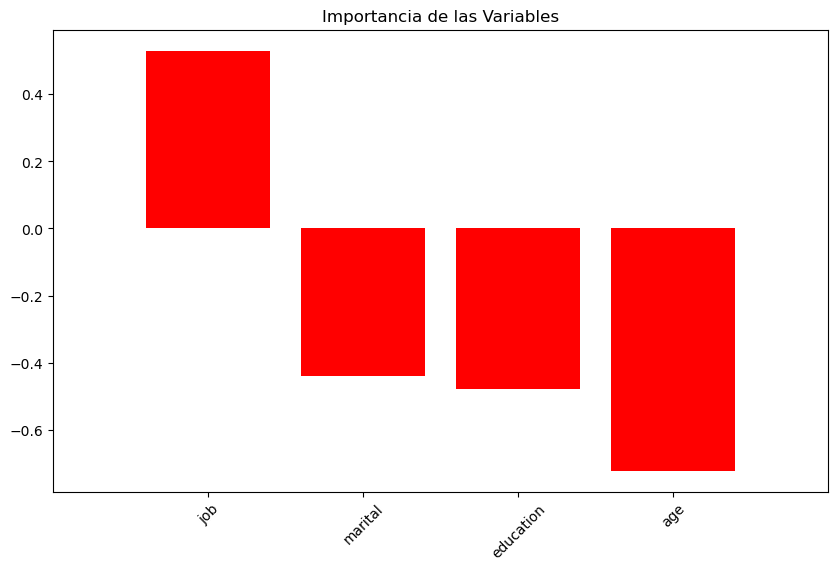

In [87]:
# Obtener la importancia de las variables CON SMOTE
importance_resampled = LR_model_resampled.coef_[0]

# Ordenar las variables por importancia
indices = np.argsort(importance_resampled)[::-1]

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.title("Importancia de las Variables")
plt.bar(range(X_train.shape[1]), importance[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), df_credit_scoring_encoder.drop(columns=['default']).columns[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Árboles de Decisión

### Entrenamiento del modelo

In [92]:
# Ajustar el Modelo SIN SMOTE
'''
criterion: criterio por el cual se realizan los divisiones en los nodos de las ramas
'''
DT_model = Arbol(criterion = 'entropy', random_state = 0)
DT_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [95]:
# Ajustar el Modelo CON SMOTE
'''
criterion: criterio por el cual se realizan los divisiones en los nodos de las ramas
'''
DT_model_resampled = Arbol(criterion = 'entropy', random_state = 0)
DT_model_resampled.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(criterion='entropy', random_state=0)

### Predicción

In [93]:
# Hacer las predicciones SIN SMOTE
#y_fit = clasificador.predict(X_train)
y_pred_dt = DT_model.predict(X_test)

Este modelo ya no sólo predice que no hay impagos (default = 0). Buena señal

In [96]:
# Hacer las predicciones CON SMOTE
#y_fit = clasificador.predict(X_train)
y_pred_dt_resampled = DT_model_resampled.predict(X_test_resampled)

### Evaluación del modelo

In [94]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada SIN SMOTE
cm = CM(y_test, y_pred_dt)
cm

array([[1071,   16],
       [  19,    2]])

In [98]:
# Otras métricas para evaluar el modelo SIN SMOTE

# Primero se convierte la matriz de confusión en variables para facilitar su cálculo
tn, fp, fn, tp = cm.ravel()

# Accuracy
accuracy = (tp+tn) / (tp+tn+fp+fn)
print(f"La exactitud/accuracy es de: {accuracy}")

# Precision
precision = tp / (tp+fp)
print(f"La precisión es de: {precision}")

# Recall
recall = tp / (tp+fn)
print(f"La sensibilidad/recall es de: {recall}")

# Specificity
specificity = tn / (tn+fp)
print(f"La especificidad/specificity es de: {specificity}")

# F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"La f1 score es de: {f1}")

La exactitud/accuracy es de: 0.9684115523465704
La precisión es de: 0.1111111111111111
La sensibilidad/recall es de: 0.09523809523809523
La especificidad/specificity es de: 0.985280588776449
La f1 score es de: 0.10256410256410256


Interpretación:
- El modelo ha interpretado correctamente el 96,84% de las predicciones
- De las predicciones que el modelo ha interpretado como positivas, ha acertado en el 11,11% de ellas
- De todos los positivos reales que hay, el modelo ha identificado bien el 9,52% de ellos
- De todos los negativos que hay, el modelo ha identificado bien el 98,52% de ellos
- El F1 Score es del 10,26%, indicando esto que el modelo no es muy robusto y no hay un buen equilibrio entre precisión y sensibilidad

In [100]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada CON SMOTE
cm_resampled = CM(y_test_resampled, y_pred_dt_resampled)
cm_resampled

array([[1067,   28],
       [  70,  469]])

In [102]:
# Otras métricas para evaluar el modelo CON SMOTE

# Primero se convierte la matriz de confusión en variables para facilitar su cálculo
tn_resampled, fp_resampled, fn_resampled, tp_resampled = cm_resampled.ravel()

# Accuracy
accuracy_resampled = (tp_resampled+tn_resampled) / (tp_resampled+tn_resampled+fp_resampled+fn_resampled)
print(f"La exactitud/accuracy es de: {accuracy_resampled}")

# Precision
precision_resampled = tp_resampled / (tp_resampled+fp_resampled)
print(f"La precisión es de: {precision_resampled}")

# Recall
recall_resampled = tp_resampled / (tp_resampled+fn_resampled)
print(f"La sensibilidad/recall es de: {recall_resampled}")

# Specificity
specificity_resampled = tn_resampled / (tn_resampled+fp_resampled)
print(f"La especificidad/specificity es de: {specificity_resampled}")

# F1 score
f1_resampled = 2 * (precision_resampled * recall_resampled) / (precision_resampled + recall_resampled)
print(f"La f1 score es de: {f1_resampled}")

La exactitud/accuracy es de: 0.9400244798041616
La precisión es de: 0.9436619718309859
La sensibilidad/recall es de: 0.8701298701298701
La especificidad/specificity es de: 0.9744292237442922
La f1 score es de: 0.9054054054054054


Interpretación:
- El modelo ha interpretado correctamente el 94,00% de las predicciones
- De las predicciones que el modelo ha interpretado como positivas, ha acertado en el 94,37% de ellas
- De todos los positivos reales que hay, el modelo ha identificado bien el 87,01% de ellos
- De todos los negativos que hay, el modelo ha identificado bien el 97,44% de ellos
- El F1 Score es del 90,54%, indicando esto que el modelo es muy robusto y hay un buen equilibrio entre precisión y sensibilidad

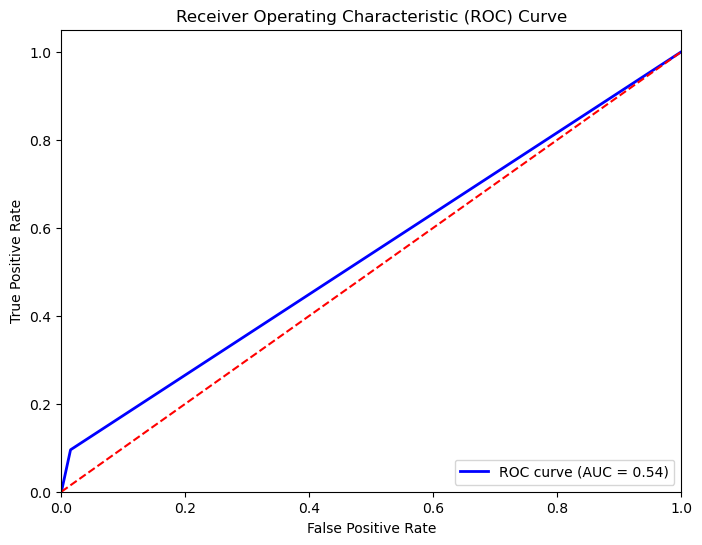

In [42]:
# Curva ROC SIN SMOTE

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Interpretación:**

Un AUC ligeramente superior a 0.5 indica que el modelo tiene cierta capacidad predictiva, pero sigue siendo relativamente bajo.

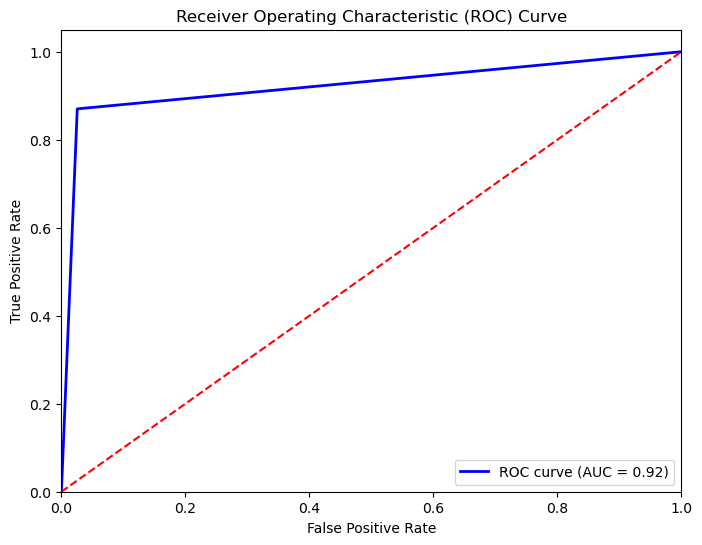

In [103]:
# Curva ROC CON SMOTE

# Calcular la curva ROC
fpr_resampled, tpr_resampled, thresholds_resampled = roc_curve(y_test_resampled, y_pred_dt_resampled)
roc_auc_resampled = auc(fpr_resampled, tpr_resampled)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_resampled, tpr_resampled, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_resampled)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Muy bueba AUC. Este modelo funciona muy bien

In [45]:
# Obtener la importancia de las variables SIN SMOTE
importances = DT_model.feature_importances_

# Crear un DataFrame para mostrar la importancia de las variables
feature_importance_df = pd.DataFrame({'Feature': df_credit_scoring_encoder.drop(columns=['default']).columns,
                                      'Importance': importances})

# Ordenar las variables por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar la importancia de las variables
print(feature_importance_df)

     Feature  Importance
0        age    0.394211
1        job    0.297339
3  education    0.204907
2    marital    0.103543


In [104]:
# Obtener la importancia de las variables CON SMOTE
importances_resampled = DT_model_resampled.feature_importances_

# Crear un DataFrame para mostrar la importancia de las variables
feature_importance_df = pd.DataFrame({'Feature': df_credit_scoring_encoder.drop(columns=['default']).columns,
                                      'Importance': importances_resampled})

# Ordenar las variables por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar la importancia de las variables
print(feature_importance_df)

     Feature  Importance
0        age    0.396581
1        job    0.314078
3  education    0.232638
2    marital    0.056703


## Conclusión

El modelo de Regresión Logística no se ajusta bien a este conjunto de datos, ya que se ha visto que el AUC es de 0.5 con la muestra original y con el balanceo de datos con SMOTE.

En cambio, el modelo de Árboles de Decisión funciona muy bien con la muestra balanceada con SMOTE, dando un AUC del 0,92. Nos quedamos con este modelo.